In [1]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
train_dir= 'F:/data/mnist/test/mnist_test.csv'
train_ratio, valid_ratio, test_ratio, k= 0.8, 0.1, 0.1, 0
lr, device, patience, pt_folder, pt_file4vqgan, pt_file4disc, pt_file4tfm, epoch_num, in_dim, out_dim, batch_size= 5e-3, 'cuda:0', 80, './', 'vqgan.pt', 'disc.pt', 'tfm.pt', 1000, 784, 128, 128

In [3]:
def load_mnist_data(dir):
    with open(dir, encoding= 'utf-8-sig') as f:
        lines= f.readlines()
    label_pic_ts= torch.from_numpy(np.asfarray([line.rstrip().split(',') for line in lines])).float()
    return label_pic_ts[:, 1:]/ 255.0, label_pic_ts[:, 0]

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # (B, 1, 28, 28)>> (B, 32, 14, 14)>> (B, 16, 7, 7)
        self.net= nn.Sequential(nn.Conv2d(in_channels= 1, out_channels= 32, kernel_size= 4, stride= 2, padding= 1), nn.ReLU(), nn.Dropout(0.3), nn.Conv2d(32, 16, 4, 2, 1), nn.ReLU())
        self.set_para()
    def set_para(self):
        nn.init.xavier_normal_(self.net[0].weight, nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.net[3].weight, nn.init.calculate_gain('relu'))
    def forward(self, x):
        return self.net(x)

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net= nn.Sequential(nn.ConvTranspose2d(16, 32, 4, 2, 1), nn.ReLU(), nn.ConvTranspose2d(32, 1, 4, 2, 1), nn.Sigmoid())
        self.set_para()
    def set_para(self):
        nn.init.xavier_normal_(self.net[0].weight, nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.net[2].weight, nn.init.calculate_gain('sigmoid'))
    def forward(self, x):
        return self.net(x)     

In [6]:
class Codebook(nn.Module):
    def __init__(self):
        super(Codebook, self).__init__()
        self.num_codebook_vectors, self.latent_dim= 20, 16
        self.beta= 0.25
        self.embedding= nn.Embedding(self.num_codebook_vectors, self.latent_dim)
        self.set_para()
    def set_para(self):
        nn.init.xavier_normal_(self.embedding.weight)
    def forward(self, z):
        # (B, 16, 7, 7)>> (B, 7, 7, 16)
        z= z.permute(0, 2, 3, 1).contiguous()
        # (B* 7* 7, 16)
        z_flattened= z.view(-1, self.latent_dim)
        # (B* 7* 7, 1)+ (20, )- (B* 7* 7, 20)= (49B, 20)
        d= torch.sum(z_flattened** 2, dim= 1, keepdim= True)+ torch.sum(self.embedding.weight** 2, dim= 1)- 2* torch.matmul(z_flattened, self.embedding.weight.T)
        # (49B,)
        min_encoding_indices= torch.argmin(d, dim= 1)
        # (49B, 16)>> (B, 7, 7, 16)
        z_q= self.embedding(min_encoding_indices).view(z.shape)
        loss= torch.mean((z_q.detach()- z)** 2)+ self.beta* torch.mean((z_q- z.detach())** 2)
        z_q= z+ (z_q- z).detach()
        # (B, 16, 7, 7)
        z_q= z_q.permute(0, 3, 1, 2)
        # (B, 16, 7, 7), (49B,). 
        return z_q, min_encoding_indices, loss

In [7]:
class VQGAN(nn.Module):
    
    def __init__(self):
        super(VQGAN, self).__init__()
        self.device= 'cuda:0'
        self.encoder= Encoder().to(self.device)
        self.decoder= Decoder().to(self.device)
        self.codebook= Codebook().to(self.device)
        self.quant_conv= nn.Conv2d(16, 16, 1).to(self.device)
        self.post_quant_conv= nn.Conv2d(16, 16, 1).to(self.device)
        self.set_para()
        
    def set_para(self):
        nn.init.xavier_normal_(self.quant_conv.weight)
        nn.init.xavier_normal_(self.post_quant_conv.weight)

    def mse_loss(self, label, pred):
        return ((label- pred)** 2).mean()

    def forward(self, x):
        encoded_images= self.encoder(x)
        quant_conv_encoded_images= self.quant_conv(encoded_images)
        codebook_mapping, codebook_indices, q_loss= self.codebook(quant_conv_encoded_images)
        post_quant_conv_mapping= self.post_quant_conv(codebook_mapping)
        decoded_images= self.decoder(post_quant_conv_mapping)
        return decoded_images, codebook_indices, q_loss

    def encode(self, x):
        # (B, 16, 7, 7)
        encoded_images= self.encoder(x)
        # (B, 16, 1, 1)
        quant_conv_encoded_images= self.quant_conv(encoded_images)
        # 
        codebook_mapping, codebook_indices, q_loss= self.codebook(quant_conv_encoded_images)
        return codebook_mapping, codebook_indices, q_loss

    def decode(self, z):
        post_quant_conv_mapping= self.post_quant_conv(z)
        decoded_images= self.decoder(post_quant_conv_mapping)
        return decoded_images

    def calculate_lambda(self, recon_loss, gan_loss):
        last_layer= self.decoder.net[-2]
        last_layer_weight= last_layer.weight
        recon_loss_grads= torch.autograd.grad(recon_loss, last_layer_weight, retain_graph= True)[0]
        gan_loss_grads= torch.autograd.grad(gan_loss, last_layer_weight, retain_graph= True)[0]
        λ= torch.norm(recon_loss_grads)/ (torch.norm(gan_loss_grads)+ 1e-10)
        return 0.8* torch.clamp(λ, 0, 1e4).detach()

    @staticmethod
    def adopt_weight(disc_factor, i, threshold, value= 0.):
        if i< threshold: disc_factor= value
        return disc_factor

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.cv= nn.Sequential(nn.Conv2d(in_channels= 1, out_channels= 32, kernel_size= 4, stride= 2, padding= 1), nn.ReLU(), nn.Dropout(0.3), nn.Conv2d(32, 16, 4, 2, 1), nn.ReLU(), nn.Dropout(0.3), nn.Conv2d(16, 1, 1), nn.Sigmoid())
        self.set_para()
    def set_para(self):
        nn.init.xavier_normal_(self.cv[0].weight, nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.cv[3].weight, nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.cv[6].weight, nn.init.calculate_gain('sigmoid'))        
    def forward(self, x):
        return self.cv(x)

In [9]:
seed= 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
os.environ['PYTHONHASHSEED'] = str(seed)    
torch.backends.cudnn.deterministic = True
pic, label= load_mnist_data(train_dir)
random_num= torch.rand(len(pic))
train_flag, valid_flag, test_flag= random_num< train_ratio, (train_ratio<= random_num)& (random_num< train_ratio+ valid_ratio), train_ratio+ valid_ratio<= random_num
train_set, valid_set, test_set= torch.utils.data.TensorDataset(pic[train_flag], label[train_flag]), torch.utils.data.TensorDataset(pic[valid_flag], label[valid_flag]), torch.utils.data.TensorDataset(pic[test_flag], label[test_flag])
train_loader, valid_loader, test_loader= torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle= True), torch.utils.data.DataLoader(valid_set, batch_size= batch_size, shuffle= False), torch.utils.data.DataLoader(test_set, batch_size= batch_size, shuffle= False)
vqgan, discriminator= VQGAN().to(device), Discriminator().to(device)
opt_vq, opt_disc= torch.optim.Adam(vqgan.parameters(), lr= lr), torch.optim.Adam(discriminator.parameters(), lr= lr)

In [10]:
best_score, score, time, first= 0, 0, 0, True
for epoch in range(epoch_num):
    for step, (pic, label) in enumerate(train_loader):
        pic= pic.view(pic.shape[0], 1, 28, 28).to(device)
        decoded_pic, _, q_loss= vqgan(pic)
        disc_real= discriminator(pic)
        disc_fake= discriminator(decoded_pic)
        # disc_factor, when to start the discriminator.
        d_loss_real= torch.mean(F.relu(1.0- disc_real))
        d_loss_fake= torch.mean(F.relu(1.0+ disc_fake))
        # why does discriminator start later?
        disc_factor= vqgan.adopt_weight(1.0, epoch* len(train_loader)+ step, threshold= 0)
        gan_loss= disc_factor* 0.5* (d_loss_real+ d_loss_fake)
        # the loss of generator,
        # For Generator, care pseudo example, the harder it is to discriminate, the better.
        recon_loss= vqgan.mse_loss(pic, decoded_pic)
        λ= vqgan.calculate_lambda(recon_loss, -d_loss_fake)
        vq_loss= recon_loss+ q_loss+ 1.0* λ* -d_loss_fake
        # update discriminator
        opt_disc.zero_grad()
        gan_loss.backward(retain_graph= True)
        # update generator
        opt_vq.zero_grad()
        vq_loss.backward()
        opt_disc.step()
        opt_vq.step()
        if step% 100== 0:print(f'epoch: {epoch+ 1}, step: {step+ 1}, vq_loss: {vq_loss}, gan_loss:{gan_loss}')
    vqgan.eval(); discriminator.eval(); val_loss= 0
    for step, (pic, label) in enumerate(valid_loader):
        pic= pic.view(pic.shape[0], 1, 28, 28).to(device)
        decoded_pic, _, q_loss= vqgan(pic)
        disc_real= discriminator(pic)
        disc_fake= discriminator(decoded_pic)
        gan_loss= 0.5* (d_loss_real+ d_loss_fake)
        recon_loss= vqgan.mse_loss(pic, decoded_pic)
        d_loss_real= torch.mean(F.relu(1.0- disc_real))
        d_loss_fake= torch.mean(F.relu(1.0+ disc_fake))
        λ= vqgan.calculate_lambda(recon_loss, -d_loss_fake)
        vq_loss= recon_loss+ q_loss+ 1.0* λ* -d_loss_fake
        val_loss+= (vq_loss.item()+ gan_loss.item())
    val_loss= val_loss/ len(valid_loader)
    # early stopping
    if first==True or val_loss< best_score- 1e-4:
        first= False
        best_score= val_loss
        time= 0
        torch.save(vqgan, f'{pt_folder}//{pt_file4vqgan}')
        torch.save(discriminator, f'{pt_folder}//{pt_file4disc}')
    elif time>= patience:
        vqgan= torch.load(f'{pt_folder}//{pt_file4vqgan}')
        discriminator= torch.load(f'{pt_folder}//{pt_file4disc}')
        break
    else:
        time+= 1
    print(f'epoch: {epoch+ 1}, early stopping time/full time: {time}/{patience}, valid loss: {val_loss* 1.0/ len(valid_loader)}')

epoch: 1, step: 1, vq_loss: -2.8742661476135254, gan_loss:0.9700944423675537
epoch: 1, early stopping time/full time: 0/80, valid loss: -1999.8682861048728
epoch: 2, step: 1, vq_loss: -15999.9462890625, gan_loss:1.0
epoch: 2, early stopping time/full time: 0/80, valid loss: -1999.8697509765625
epoch: 3, step: 1, vq_loss: -15999.958984375, gan_loss:1.0
epoch: 3, early stopping time/full time: 0/80, valid loss: -1999.8719329833984
epoch: 4, step: 1, vq_loss: -15999.974609375, gan_loss:1.0
epoch: 4, early stopping time/full time: 0/80, valid loss: -1999.87255859375
epoch: 5, step: 1, vq_loss: -15999.9794921875, gan_loss:1.0
epoch: 5, early stopping time/full time: 0/80, valid loss: -1999.872817993164
epoch: 6, step: 1, vq_loss: -15999.982421875, gan_loss:1.0
epoch: 6, early stopping time/full time: 0/80, valid loss: -1999.873062133789
epoch: 7, step: 1, vq_loss: -15999.984375, gan_loss:1.0
epoch: 7, early stopping time/full time: 0/80, valid loss: -1999.8731079101562
epoch: 8, step: 1, vq

In [11]:
vqgan= torch.load(f'{pt_folder}//{pt_file4vqgan}')
discriminator= torch.load(f'{pt_folder}//{pt_file4disc}')

In [12]:
vqgan.eval(); discriminator.eval(); pred= []
for step, (pic, label) in enumerate(test_loader):
    pic= pic.view(pic.shape[0], 1, 28, 28).to(device)
    decoded_pic, _, q_loss= vqgan(pic)
    disc_real= discriminator(pic)
    disc_fake= discriminator(decoded_pic)
    pred.append(decoded_pic.detach().cpu())
pred= torch.cat(pred, dim= 0)

In [13]:
def show_mnist(images):
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img in zip(figs, images):
        f.imshow(img.view(28, 28), cmap= 'gray')
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

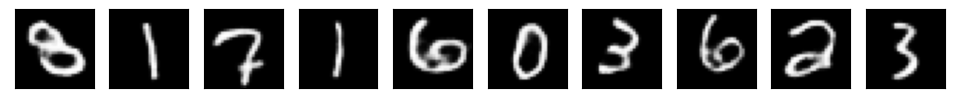

In [14]:
show_mnist(pred[0: 10])

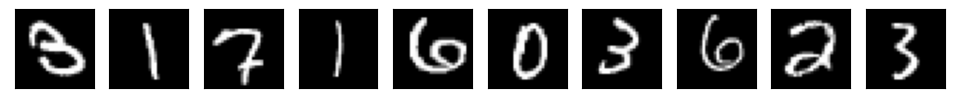

In [15]:
show_mnist(test_set[0: 10][0])

### GPT model

In [16]:
"""
taken from: https://github.com/karpathy/minGPT/
GPT model:
- the initial stem consists of a combination of token encoding and a positional encoding
- the meat of it is a uniform sequence of Transformer blocks
    - each Transformer is a sequential combination of a 1-hidden-layer MLP block and a self-attention block
    - all blocks feed into a central residual pathway similar to resnets
- the final decoder is a linear projection into a vanilla Softmax classifier
"""

'\ntaken from: https://github.com/karpathy/minGPT/\nGPT model:\n- the initial stem consists of a combination of token encoding and a positional encoding\n- the meat of it is a uniform sequence of Transformer blocks\n    - each Transformer is a sequential combination of a 1-hidden-layer MLP block and a self-attention block\n    - all blocks feed into a central residual pathway similar to resnets\n- the final decoder is a linear projection into a vanilla Softmax classifier\n'

In [17]:
import math
import torch
import torch.nn as nn
from torch.nn import functional as F

In [18]:
class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1
    # 20, 16
    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k, v in kwargs.items():
            # 设置属性值
            setattr(self, k, v)

In [19]:
class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        mask = torch.tril(torch.ones(config.block_size,
                                     config.block_size))
        if hasattr(config, "n_unmasked"):
            mask[:config.n_unmasked, :config.n_unmasked] = 1
        self.register_buffer("mask", mask.view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head

    def forward(self, x, layer_past=None):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)

        present = torch.stack((k, v))
        if layer_past is not None:
            past_key, past_value = layer_past
            k = torch.cat((past_key, k), dim=-2)
            v = torch.cat((past_value, v), dim=-2)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        if layer_past is None:
            att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))

        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))
        return y, present  # TODO: check that this does not break anything

In [20]:
class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),  # nice
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x, layer_past=None, return_present=False):
        # TODO: check that training still works
        if return_present:
            assert not self.training
        # layer past: tuple of length two with B, nh, T, hs
        attn, present = self.attn(self.ln1(x), layer_past=layer_past)

        x = x + attn
        x = x + self.mlp(self.ln2(x))
        if layer_past is not None or return_present:
            return x, present
        return x

In [21]:
class GPT(nn.Module):
    """  the full GPT language model, with a context size of block_size """
    # 20, 
    def __init__(self, vocab_size, block_size, n_layer=12, n_head=8, n_embd=256,
                 embd_pdrop=0., resid_pdrop=0., attn_pdrop=0., n_unmasked=0):
        super().__init__()
        config = GPTConfig(vocab_size=vocab_size, block_size=block_size,
                           embd_pdrop=embd_pdrop, resid_pdrop=resid_pdrop, attn_pdrop=attn_pdrop,
                           n_layer=n_layer, n_head=n_head, n_embd=n_embd,
                           n_unmasked=n_unmasked)
        # input embedding stem
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))
        self.drop = nn.Dropout(config.embd_pdrop)
        # transformer
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.block_size = config.block_size
        self.apply(self._init_weights)
        self.config = config

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, idx, embeddings=None):
        # idx, (B, 49)>> (B, 49, 16)
        token_embeddings = self.tok_emb(idx)  # each index maps to a (learnable) vector
        if embeddings is not None:  # prepend explicit embeddings
            token_embeddings = torch.cat((embeddings, token_embeddings), dim=1)
        # t= 49
        t = token_embeddings.shape[1]
        # 49<= 49
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."
        # (B, 49, 16)
        position_embeddings = self.pos_emb[:, :t, :]  # each position maps to a (learnable) vector
        x = self.drop(token_embeddings + position_embeddings)
        x = self.blocks(x)
        x = self.ln_f(x)
        # (B, 49, 20)
        logits = self.head(x)
        return logits, None

In [22]:
class Transformer(nn.Module):
    def __init__(self, vqgan):
        super(Transformer, self).__init__()
        self.sos_token= 0
        self.vqgan= vqgan
        # codebook vector num, block_size , layer num, head, embed num
        self.transformer= GPT(30, 49, 2, 4, 16)
        self.pkeep= 0.5

    def encode_to_z(self, x):
        # (B, 16, 7, 7), (49B,),
        quant_z, indices, _= self.vqgan.encode(x)
        # (B, 49)
        indices= indices.view(quant_z.shape[0], -1)
        return quant_z, indices

    def z_to_image(self, indices):
        # (B, 49, 16)>> (B, 7, 7, 16)
        ix_to_vec= self.vqgan.codebook.embedding(indices).reshape(indices.shape[0], 7, 7, 16)
        # (B, 16, 7, 7)
        ix_to_vec= ix_to_vec.permute(0, 3, 1, 2)
        # (B, 1, 28, 28)
        image= self.vqgan.decode(ix_to_vec)
        # (28, 28, 1)
        return (image[0]).permute(1, 2, 0)

    def forward(self, x):
        # x, (B, 1, 28, 28); indices, (B, 49)
        _, indices= self.encode_to_z(x)
        # (B, 1)
        sos_tokens= torch.ones(x.shape[0], 1)* self.sos_token
        sos_tokens= sos_tokens.long().to('cuda')
        # mask, (B, 49)
        mask= torch.bernoulli(self.pkeep* torch.ones(indices.shape, device= indices.device))
        mask= mask.round().to(dtype= torch.int64)
        # value: 0- 19; size: (B, 49).
        random_indices= torch.randint_like(indices, 20)
        new_indices= mask* indices+ (1- mask)* random_indices
        # new_indices, (B, 50)
        new_indices= torch.cat((sos_tokens, new_indices), dim= 1)
        # (B, 49)
        target= indices
        # (B, 49, 20),
        logits, _= self.transformer(new_indices[:, :-1])
        # (B, 49, 20); (B, 49)
        return logits, target

    def top_k_logits(self, logits, k):
        # logits, (B, 49, 20); k, 2.
        # v, (B, 49, 2); ix, (B, 49, 2).
        v, ix= torch.topk(logits, k)
        out= logits.clone()
        # mask on out, < top k.
        out[out< v[:,[-1]]]= -float('inf')
        return out

    @torch.no_grad()
    def sample(self, x, c, steps, temperature= 1.0, topk= 10):
        # x, (B, 24); c, (B, 1); steps, 25.
        self.transformer.eval()
        # x, (B, 25).
        x= torch.cat((c, x), dim= 1)
        # for each step
        for k in range(steps):
            # x, (B, 25); logits, (B, 25, 20).
            logits, _= self.transformer(x)
            # (B, 1, 20)
            logits= logits[:, -1, :]/ temperature
            if topk is not None:
                logits= self.top_k_logits(logits, topk)
            # (B, 1, 20)
            probs= F.softmax(logits, dim= -1)
            # (B, 1)
            ix= torch.multinomial(probs, num_samples= 1)
            # (B, 26)
            x= torch.cat((x, ix), dim= 1)
        # (B, 49)
        x= x[:, c.shape[1]:]
        self.transformer.train()
        return x

    @torch.no_grad()
    def log_images(self, x):
        log= dict()
        # (B, 49)
        _, indices= self.encode_to_z(x)
        # (B, 1)
        sos_tokens= torch.ones(x.shape[0], 1)* self.sos_token
        sos_tokens= sos_tokens.long().to('cuda')
        # (B, 24)
        start_indices= indices[:, :indices.shape[1]// 2]
        # (B, 24); (B, 1); 49- 24= 25>> (B, 49)
        sample_indices= self.sample(start_indices, sos_tokens, steps= indices.shape[1]- start_indices.shape[1])
        # (B, 49)>> (B, 1, 28, 28)
        half_sample= self.z_to_image(sample_indices)
        start_indices= indices[:, :0]
        sample_indices= self.sample(start_indices, sos_tokens, steps= indices.shape[1])
        full_sample= self.z_to_image(sample_indices)
        x_rec= self.z_to_image(indices)
        log['input']= x
        log['rec']= x_rec
        log['half_sample']= half_sample
        log['full_sample']= full_sample
        return log, torch.stack((x[0].permute(1, 2, 0), x_rec, half_sample, full_sample))

In [23]:
tfm= Transformer(vqgan).to(device)
opt_tf= torch.optim.Adam(tfm.parameters(), lr= lr)

In [24]:
best_score, score, time, first= 0, 0, 0, True
for epoch in range(epoch_num):
    for step, (pic, label) in enumerate(train_loader):
        pic= pic.view(pic.shape[0], 1, 28, 28).to(device)
        logits, targets= tfm(pic)
        loss= F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
        opt_tf.zero_grad()
        loss.backward()
        opt_tf.step()
        if step% 100== 0: print(f'epoch: {epoch+ 1}, step: {step+ 1}, loss: {loss}')
    tfm.eval();val_loss= 0
    for step, (pic, label) in enumerate(valid_loader):
        pic= pic.view(pic.shape[0], 1, 28, 28).to(device)
        logits, targets= tfm(pic)
        loss= F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
        val_loss+= loss.item()
    val_loss= val_loss/ len(valid_loader)
    # early stopping
    if first==True or val_loss< best_score- 1e-4:
        first= False
        best_score= val_loss
        time= 0
        torch.save(tfm, f'{pt_folder}//{pt_file4tfm}')
    elif time>= patience:
        tfm= torch.load(f'{pt_folder}//{pt_file4tfm}')
        break
    else:
        time+= 1
    print(f'epoch: {epoch+ 1}, early stopping time/full time: {time}/{patience}, valid loss: {val_loss* 1.0/ len(valid_loader)}')

epoch: 1, step: 1, loss: 3.3929390907287598
epoch: 1, early stopping time/full time: 0/80, valid loss: 0.1882128305733204
epoch: 2, step: 1, loss: 1.5431443452835083
epoch: 2, early stopping time/full time: 0/80, valid loss: 0.18160506710410118
epoch: 3, step: 1, loss: 1.4612029790878296
epoch: 3, early stopping time/full time: 0/80, valid loss: 0.17802437022328377
epoch: 4, step: 1, loss: 1.4525023698806763
epoch: 4, early stopping time/full time: 0/80, valid loss: 0.1748204380273819
epoch: 5, step: 1, loss: 1.4139416217803955
epoch: 5, early stopping time/full time: 0/80, valid loss: 0.17368420585989952
epoch: 6, step: 1, loss: 1.3782861232757568
epoch: 6, early stopping time/full time: 0/80, valid loss: 0.1722600143402815
epoch: 7, step: 1, loss: 1.3980712890625
epoch: 7, early stopping time/full time: 0/80, valid loss: 0.1711117047816515
epoch: 8, step: 1, loss: 1.371095895767212
epoch: 8, early stopping time/full time: 0/80, valid loss: 0.17089124396443367
epoch: 9, step: 1, loss:

In [25]:
tfm= torch.load(f'{pt_folder}//{pt_file4tfm}')

In [40]:
img= test_set[2][0].view(1, 1, 28, 28).cuda()
log, sampled_imgs= tfm.log_images(img)

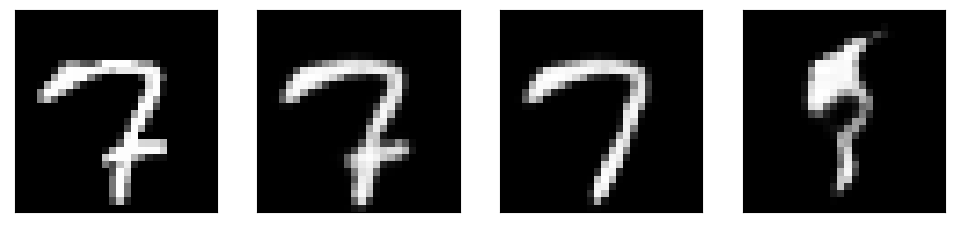

In [41]:
imgs= [img.detach().cpu().squeeze() for img in sampled_imgs]
show_mnist(imgs)